# Alpha Shapes

**Date:** 2020-08-18<br>
**Data:** MERFISH large dataset <br>
**Description:** Look at how alphashape package can be used to approximate area

## Load Libraries

We will be using some custom modules to reduce the amount of code in the notebook, namely: `spatstat`, `datasets` and `utils`.

In [1]:
%load_ext Cython
%load_ext autoreload
%autoreload 2

In [11]:
import spatstat as sp
import datasets
import utils as ut

import sys
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import alphashape


import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path as osp
import os

## Load and Prepare Data

First set some global variables to make things easier for us

In [5]:
DATA_PTH = '/home/alma/w-projects/stx/data/MERFISH_MOp_MERFISH_MOp_0502.h5ad'

Inspect the data to make sure everything looks allright

In [6]:
all_data = ad.read_h5ad(DATA_PTH)
all_data.obs

,volume,x,y,AP_distance,soma_depth,label,subclass,class_label,specimen_id,batch_id,slice
index,,,,,,,,,,,
10000143038275111136124942858811168393,992.830060,4738.397298,3075.327399,400.0,959.227100,Astro_1,Astrocytes,Other,2,4,31
100001798412490480358118871918100400402,610.091871,-3964.711404,1451.889047,1690.0,1246.938980,Endo,Endothelial,Other,2,5,160
100006878605830627922364612565348097824,148.277718,805.843523,1215.035473,1180.0,7.369782,SMC,SMC,Other,2,6,109
100007228202835962319771548915451072492,249.515471,1348.686198,-3589.955255,700.0,1123.956211,Endo,Endothelial,Other,1,2,71
100009332472089331948140672873134747603,1779.831996,-3584.650904,-1883.105955,2280.0,324.069916,L23_IT_3,L23_IT,Glutamatergic,2,5,219
...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,1208.963097,890.666985,1069.905972,2500.0,198.887653,Pvalb_1,Pvalb,GABAergic,1,5,251
99989592830367590092304100078674096866,611.167089,1913.334949,1280.947292,2700.0,772.996776,L5_PT_5,L5_PT,Glutamatergic,2,3,261
99991756591196613545069880666241120777,130.928366,3847.387896,3589.662245,1110.0,623.739723,L45_IT_4,L45_IT,Glutamatergic,1,3,112


Extract cells from the same datasets, for each subset extraction will be done based on:

* specimen id - only cells from the same specimen should be used 
* batch id - ensure cells come from the same batch
* slice - ensure cells comre from the same slice

all data will be stored as `MerfishData` objects in the `data` dictionary, keys are `[batch_id]_[slice]`.

we will use the `subclass` types in our analysis, to change this simply modify the definition of the `type_colname` variable.

_comment_ : it seems as if batch id is redundant for unique selection, slice id's would be enough to get the same results. Have not confirmed yet.

In [7]:
type_colname = "subclass"
data = dict()
ids = list()
mask_1 = all_data.obs["specimen_id"].values == 1

for batch_id in all_data.obs["batch_id"].unique():
    mask_2 = all_data.obs["batch_id"] == batch_id
    slice_ids = all_data.obs[mask_1 & mask_2].slice.unique()
    for slice_id in slice_ids:
        ids.append([batch_id, slice_id])

for batch,slice_id in ids:
    
    mask_2 = all_data.obs["batch_id"].values == batch
    mask_3 = all_data.obs["slice"].values == slice_id
    
    _subset = all_data[mask_1 & mask_2 & mask_3]
    data.update({"{}_{}".format(batch,slice_id):datasets.MerfishData(data = _subset,
                                                                    type_colname= type_colname)})

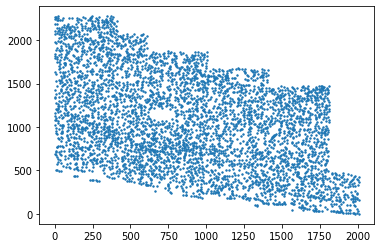

In [10]:
sample = list(data.keys())[10]
crd = data[sample].crd
plt.scatter(crd[:,0],crd[:,1], s = 2)
plt.show()

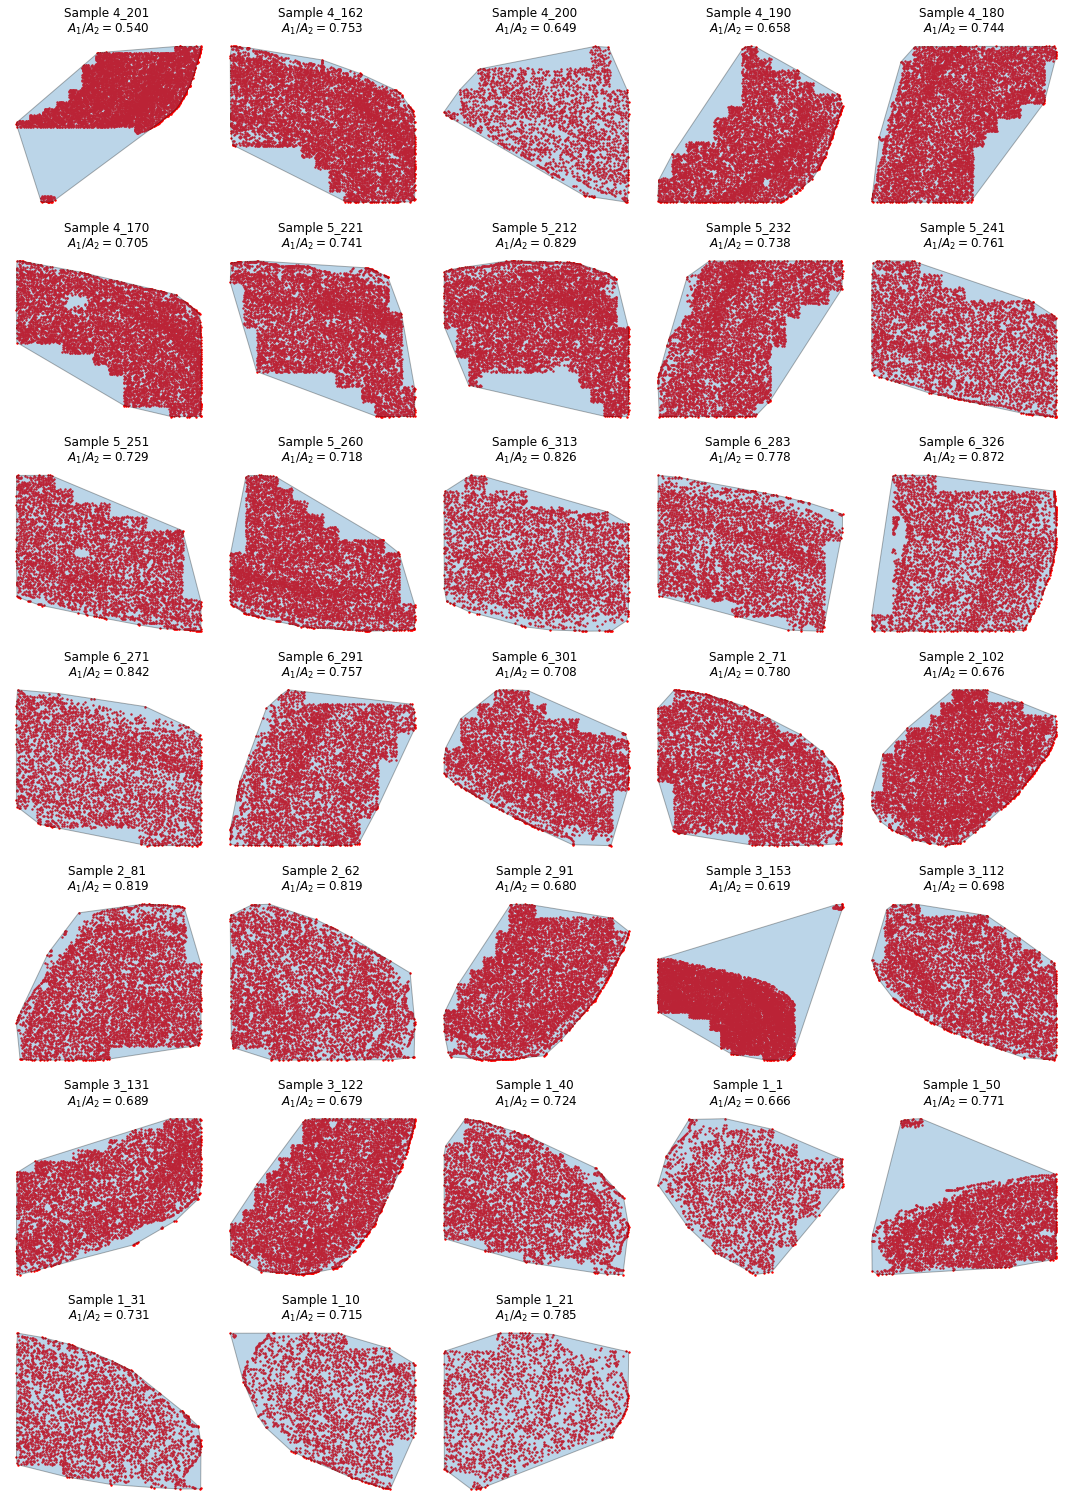

In [51]:

n_cols = 5
n_rows = int(np.ceil(len(data) / n_cols))
figsize =(n_cols * 3, n_rows * 3 )


fig,ax = plt.subplots(n_rows,n_cols,figsize = figsize )
ax = ax.flatten()

for k,s in enumerate(data.keys()):
    alpha_shape = alphashape.alphashape(data[s].crd,0.0)
    area_rect = data[s].area
    area_alpha = alpha_shape.area
    frac = area_alpha / area_rect
    ax[k].set_title("Sample {} \n".format(s) + r"$A_1 / A_2=$" + "{:0.3f}".format(frac))
    ax[k].add_patch(PolygonPatch(alpha_shape, alpha=0.3))
    ax[k].scatter(data[s].crd[:,0],data[s].crd[:,1],s = 2,c = "red")
    ax[k].axis("off")

for k in range(len(data),n_cols*n_rows):
    ax[k].set_visible(False)

fig.tight_layout()
plt.show()


In [58]:
help(np.unique)

Help on function unique in module numpy:

unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)
    Find the unique elements of an array.
    
    Returns the sorted unique elements of an array. There are three optional
    outputs in addition to the unique elements:
    
    * the indices of the input array that give the unique values
    * the indices of the unique array that reconstruct the input array
    * the number of times each unique value comes up in the input array
    
    Parameters
    ----------
    ar : array_like
        Input array. Unless `axis` is specified, this will be flattened if it
        is not already 1-D.
    return_index : bool, optional
        If True, also return the indices of `ar` (along the specified axis,
        if provided, or in the flattened array) that result in the unique array.
    return_inverse : bool, optional
        If True, also return the indices of the unique array (for the specified
        axis, if pro

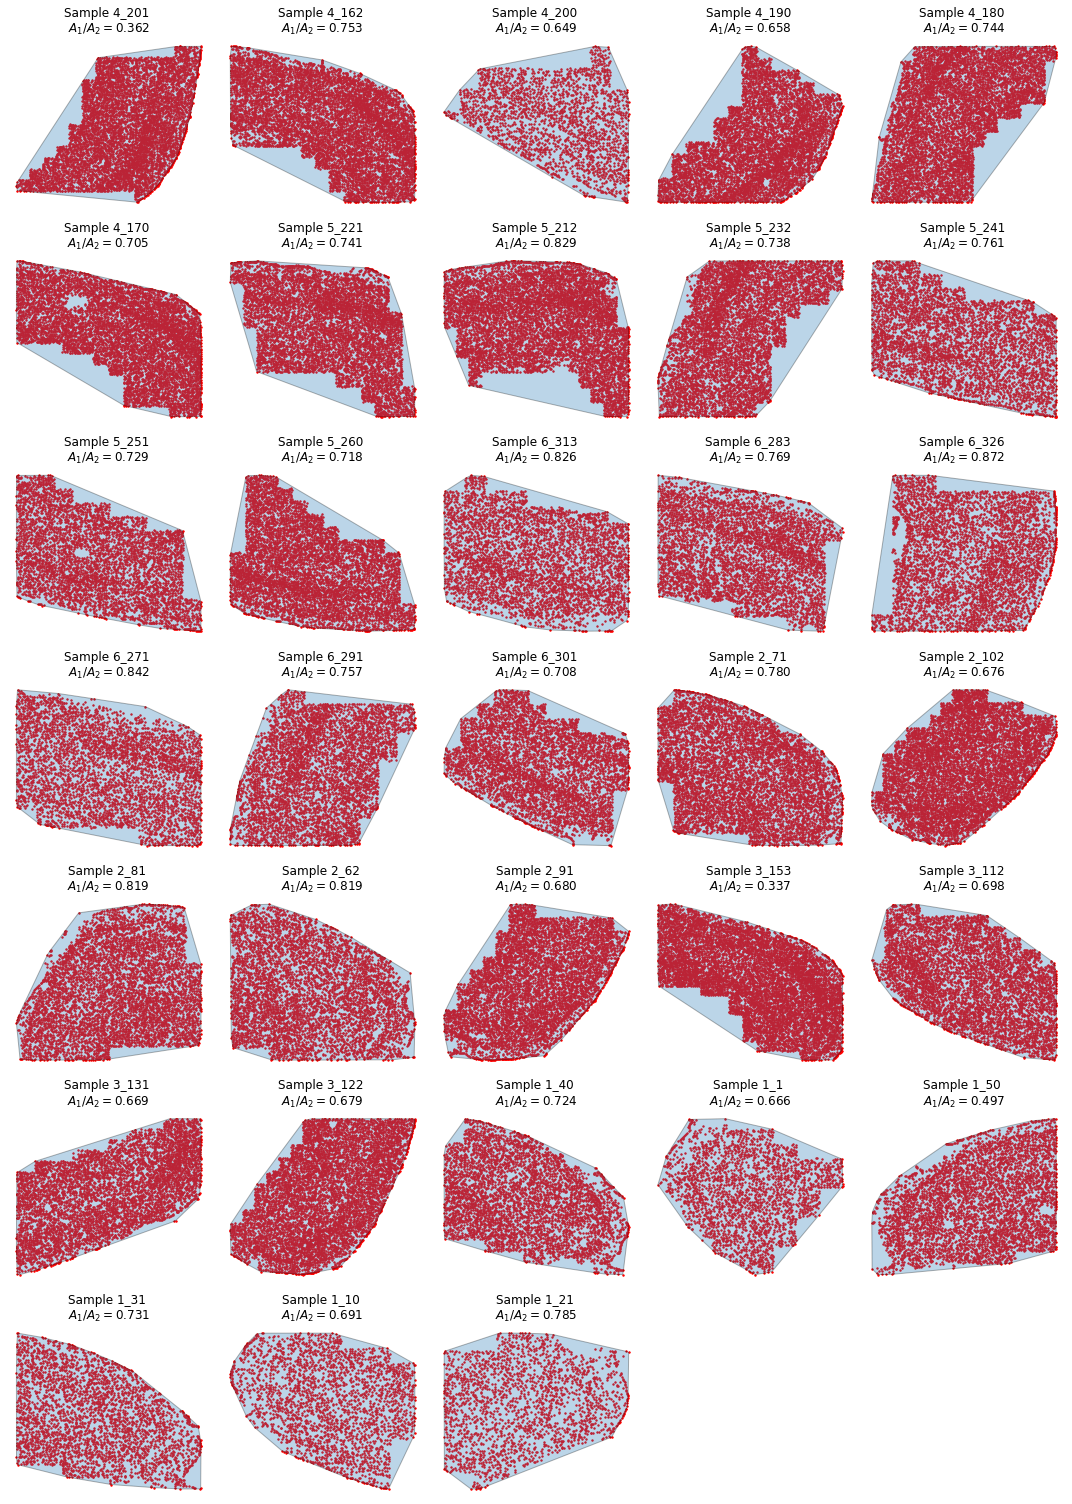

In [62]:
from sklearn.cluster import DBSCAN as db
from scipy.spatial.distance import cdist

sample = "4_201"


n_cols = 5
n_rows = int(np.ceil(len(data) / n_cols))
figsize =(n_cols * 3, n_rows * 3 )


fig,ax = plt.subplots(n_rows,n_cols,figsize = figsize )
ax = ax.flatten()

for k,s in enumerate(data.keys()):
    
    D = cdist(data[s].crd,data[s].crd)
    D[D==0] = np.inf
    eps = np.max(np.min(D,axis = 1))
    res = db(eps = 2*eps).fit_predict(data[s].crd)
    
    labs,cnts = np.unique(res, return_counts = True)
    maxc = labs[np.argmax(cnts)]
    sel = res == maxc
    
    crd = data[s].crd[sel]
    
    alpha_shape = alphashape.alphashape(crd,0.0)
    area_rect = data[s].area
    area_alpha = alpha_shape.area
    frac = area_alpha / area_rect
    ax[k].set_title("Sample {} \n".format(s) + r"$A_1 / A_2=$" + "{:0.3f}".format(frac))
    ax[k].add_patch(PolygonPatch(alpha_shape, alpha=0.3))
    ax[k].scatter(crd[:,0],crd[:,1],s = 2,c = "red")
    ax[k].axis("off")

for k in range(len(data),n_cols*n_rows):
    ax[k].set_visible(False)

fig.tight_layout()
plt.show()
